# Installing libraries

In [1]:
!pip install pmdarima
!pip install gluonts
!pip install mxnet
!pip install shap

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 15.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 573kB 5.6MB/s 
     |████████████████████████████████| 8.6MB 11.1MB/s 
     |████████████████████████████████| 194kB 39.0MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp37-cp37m-linux_x86_64.whl size=68381 sha256=06d957943822c5316b2ae4ba14d6655ec5d85e8cc91596d78b82f36753bdc723
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson
     |████████████████████████████████| 46.9MB 59kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 358kB 4.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m

# Importing Libraries

In [86]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb
import lightgbm as lgb
import gluonts
import matplotlib.pyplot as plt
from math import sqrt
import shap
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA
from random import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
from tqdm import tqdm, tqdm_notebook
from pandas_datareader import data as pdr # For downloading datasets
from datetime import datetime
from keras.layers.wrappers import TimeDistributed
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
warnings.filterwarnings("ignore") 

# Downloading and reading google dataset

In [3]:
ibm = pdr.DataReader('IBM', 'yahoo',  start=datetime(2021, 1, 1), end=datetime(2021, 3, 31))
ibm.to_csv('ibm_stock.csv', sep=',')
print(ibm.head())

                  High         Low  ...     Volume   Adj Close
Date                                ...                       
2021-01-04  125.919998  123.040001  ...  5179200.0  122.305649
2021-01-05  126.680000  124.610001  ...  6114600.0  124.476639
2021-01-06  131.880005  126.720001  ...  7956700.0  127.585091
2021-01-07  130.460007  128.259995  ...  4507400.0  127.289062
2021-01-08  129.320007  126.980003  ...  4676200.0  126.835121

[5 rows x 6 columns]


In [4]:
data = pd.read_csv('ibm_stock.csv',parse_dates=['Date'])
data.set_index('Date',inplace=True)

# Some declarations of basic functions

In [5]:
EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)
def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]
def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:],
                      predicted[seasonality:]) / (_error(actual[seasonality:],
                                                         _naive_forecasting(actual,
                                                                            seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(
            a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error

    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(
        np.abs(
            _relative_error(
                actual,
                predicted,
                benchmark)))


def mbrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) ==
                    np.sign(predicted[1:] - predicted[:-1])).astype(int))


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ Mean forecast error(or Forecast Bias) """
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray,
    predicted: np.ndarray,
    metrics=(
        "mae",
        "rmse",
        "mape",
        "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

# Some plotting functions for further use

In [6]:
def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["mae"].sort_values().index], )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["rmse"].sort_values().index], )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["mape"].sort_values().index], )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.savefig("results/metrics.png")
    plt.show()

# Time series forecasting

**Preparing data before modeling**

In [7]:
resultsDict={}
predictionsDict={}
split_date ='2021-03-02'
df_training = data.loc[data.index <= split_date]
df_test = data.loc[data.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('training.csv')
df_test.to_csv('test.csv')

40 days of training data 
 21 days of testing data 


**Adding the naive mean average value**

In [8]:
mean = df_test.Close.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Close, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.Close, df_test.Open)
predictionsDict['Yesterdays value'] = df_test.Close.values

## Univariate-time-series-forecasting

### Simple Exponential Smoothing (SES)

In [9]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train['Adj Close'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test['Adj Close'], yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 131.91it/s]


### Holt Winter’s Exponential Smoothing or Triple Exponential Smoothing (HWES)

In [10]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train['Adj Close'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['Adj Close'], yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 132.55it/s]


### Autoregression (AR) and plotting the result


In [11]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = AR(temp_train['Adj Close'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['Adj Close'], yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 229.59it/s]


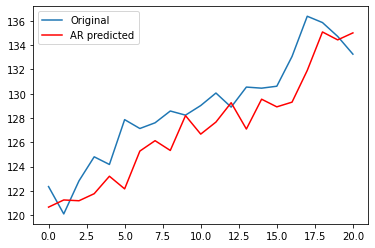

In [12]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

### Moving Average (MA) and plotting the results

In [13]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = ARMA(temp_train['Adj Close'], order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['Adj Close'], yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 32.46it/s]


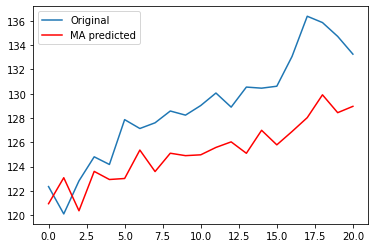

In [14]:
plt.plot(df_test.Close.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA) and plotting the results

In [15]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train['Adj Close'], order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test['Adj Close'], yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 31.98it/s]


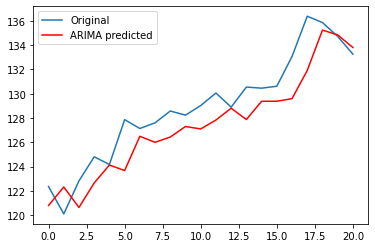

In [16]:
plt.plot(df_test.Close.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

#### Auto ARIMA

In [17]:
autoModel = pm.auto_arima(df_training['Adj Close'], trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
autoModel.fit(df_training.Close)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=191.497, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=188.388, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.911, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=189.153, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186.404, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.462 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [18]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test['Adj Close']))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train['Adj Close'], order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(df_test['Adj Close'], yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 21/21 [00:00<00:00, 156.61it/s]


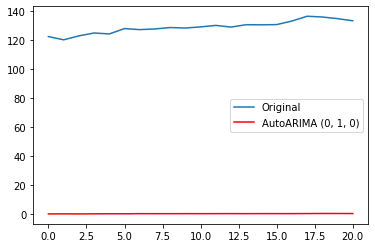

In [19]:
plt.plot(df_test['Adj Close'].values , label='Original')
plt.plot(yhat.values,color='red',label='AutoARIMA {0}'.format(order))
plt.legend()

## Multivariate time series forecasting

In [20]:
## ADD time features to our model
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [21]:
X_train_df, y_train = create_time_features(df_training, target='Adj Close')
X_test_df, y_test = create_time_features(df_test, target='Adj Close')
scaler = StandardScaler() 
scaler.fit(X_train_df) #No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

#### Randomforest

In [22]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Close, yhat)
predictionsDict['Randomforest'] = yhat

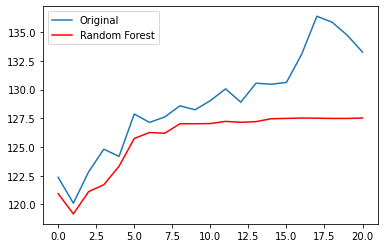

In [23]:
plt.plot(df_test.Close.values , label='Original')
plt.plot(yhat,color='red',label='Random Forest')
plt.legend()

### Support vector machines

In [24]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.Close, yhat)
predictionsDict['SVM RBF'] = yhat

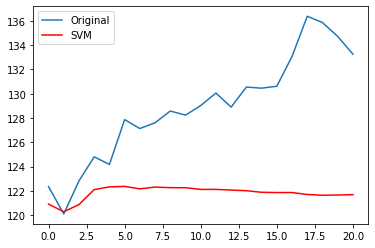

In [25]:
plt.plot(df_test.Close.values , label='Original')
plt.plot(yhat,color='red',label='SVM')
plt.legend()

### Nearest neighbors

In [26]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.Close, yhat)
predictionsDict['Kneighbors'] = yhat

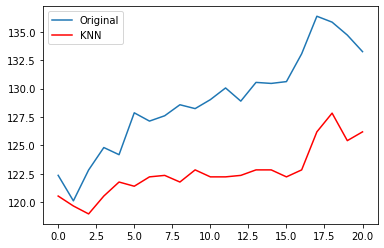

In [27]:
plt.plot(df_test.Close.values , label='Original')
plt.plot(yhat,color='red',label='KNN')
plt.legend()

### Deep learning

#### Tensorlfow LSTM

In [28]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [74]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [75]:
simple_lstm_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               73728     
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 106,881
Trainable params: 106,881
Non-trainable params: 0
_________________________________________________________________


In [79]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)#,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/50
200/200 [==============================] - 4s 12ms/step - loss: 21.4826 - val_loss: 31.4340
Epoch 2/50
200/200 [==============================] - 2s 10ms/step - loss: 5.5212 - val_loss: 80.2561
Epoch 3/50
200/200 [==============================] - 2s 10ms/step - loss: 5.0788 - val_loss: 58.3973
Epoch 4/50
200/200 [==============================] - 2s 10ms/step - loss: 4.7616 - val_loss: 51.5332
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 4.5193 - val_loss: 51.2740
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 4.3015 - val_loss: 50.9688
Epoch 7/50
200/200 [==============================] - 2s 10ms/step - loss: 4.1442 - val_loss: 51.3830
Epoch 8/50
200/200 [==============================] - 2s 10ms/step - loss: 3.9565 - val_loss: 51.0743
Epoch 9/50
200/200 [==============================] - 2s 10ms/step - loss: 3.8299 - val_loss: 50.8233
Epoch 10/50
200/200 [==============================] - 2s 10ms/step - loss: 3.709

In [80]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

# Applying Hybrid Approach

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=X_train_w.shape[-2:]))
model.add(RepeatVector(1))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='rmsprop')

In [76]:
model.summary()
EVALUATION_INTERVAL = 200
EPOCHS = 50

model_history = model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 200)               172800    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 200)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 1, 200)            320800    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 100)            20100     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 1)              101       
Total params: 513,801
Trainable params: 513,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
200/200 [==============================] - 17s 70ms/step - loss: 117.9128 - val_loss: 8.4011
Epoch 2/5

In [77]:
yhat = model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['CNN LSTM'] = evaluate(y_test,yhat)
predictionsDict['CNN LSTM'] = yhat

## Ensembling

In [85]:
models = ['CNN LSTM',
          'Tensorflow simple LSTM',
 'SVM RBF',
 'Randomforest',
 'Kneighbors']
resis = pd.DataFrame(data={k: df_test.Close.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient()

Residuals correlation


,CNN LSTM,Tensorflow simple LSTM,SVM RBF,Randomforest,Kneighbors
CNN LSTM,1.000000,-0.628381,-0.771633,-0.819029,-0.565414
Tensorflow simple LSTM,-0.628381,1.000000,0.747282,0.593568,0.663163
SVM RBF,-0.771633,0.747282,1.000000,0.881025,0.912431
Randomforest,-0.819029,0.593568,0.881025,1.000000,0.710643
Kneighbors,-0.565414,0.663163,0.912431,0.710643,1.000000


In [87]:
predictionsDict['CNN LSTM+Kneighbors'] = (predictionsDict['CNN LSTM'] + predictionsDict['Kneighbors'])/2
resultsDict['CNN LSTM+Kneighbors'] = evaluate(df_test.Close.values,predictionsDict['CNN LSTM+Kneighbors'])

In [88]:
print(resultsDict['CNN LSTM+Kneighbors'])

{'mae': 2.6108194078717992, 'rmse': 3.37386006033496, 'mape': 0.02015511275790371, 'r2': 0.3813375280634935}


# End of Forecasting